In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definizione del problema

Il dataset in esame (https://www.kaggle.com/datasets/ananthr1/weather-prediction/data) contiene dati sulle condizioni meteorologiche di Seattle dal 01/01/2012 al 31/12/2015.
L'obiettivo è quello di prevedere le condizioni meteo (es. sole, pioggia, nebbia) di un determinato giorno, si tratta quindi di un problema di classificazione.                                   

In [8]:
dataset = pd.read_csv("seattle-weather.csv")

# Analisi del dataset

In [9]:
dataset.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


Descrizione delle feature:
- date -> data di riferimento
- precipitation -> valore numerico che indica l'intensità delle precipitazioni in qualunque forma (pioggia, neve, ...)
- temp_max -> temperatura massima giornaliera
- temp_min -> temperaura minima giornaliera
- wind -> velocità del vento
- weather -> etichetta che indica le condizioni meteorologiche della giornata

In questo caso la feature target è "weather", ossia si vuole prevedere le condizioni meteorologiche di una certa giornata.

Almeno inizialmente saranno prese in considerazione tutte le altre feature ai fini della predizione.

Si vuole ora verificare che sia effettivamente presente una riga per ogni data nell'intervallo. 

In [10]:
# Si crea una serie contentente tutte le date presenti del dataset
dates = pd.to_datetime(dataset['date'])

# Si crea l'intervallo completo tra la data minima e massima
date_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')

# Si crea una serie con le date mancanti e si verifica che sia vuota
missing_dates = date_range.difference(dates)
print(missing_dates.empty)


True


Tutte le date nell'intervallo risultano presenti, questo rende il dataset comodamente utilizzabile come serie temporale. Si decide quindi di effettuare un parsing delle date e impostarle come indice del dataset.

In [37]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [16]:
print(dataset.describe())

print("\n")

nan_rows = dataset.isna().any(axis=1).sum()
print("Numero di righe contenenti valori Nan: " + str(nan_rows))

       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


Numero di righe contenenti valori Nan: 0


Il Dataset non presenta righe contenenti valori NaN, non è quindi necessario alcun intervento di *fill*.

## Analisi del bilanciamento delle classi

Si vuole ora verificare in che percentuale compaiono le classi della colonna target.

<function matplotlib.pyplot.show(close=None, block=None)>

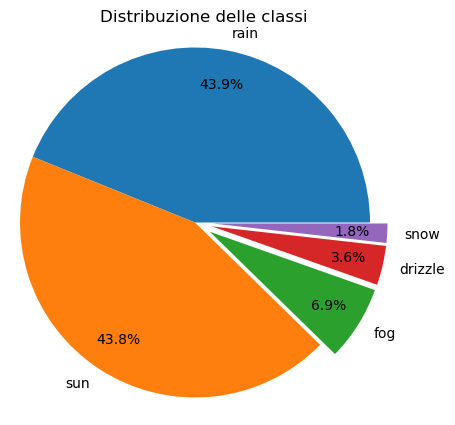

In [36]:
label_counts = dataset['weather'].value_counts()

explode = [0.1 if count / label_counts.sum() < 0.2 else 0 for count in label_counts]

plt.figure(figsize=(5,5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', pctdistance=0.8,
        explode=explode)

plt.title("Distribuzione delle classi")
plt.axis('equal')
plt.show


A causa della natura del dataset le classi risultano ovviamente molto sbilanciate, è tuttavia necessario procedere con cautela nel caso si intendano applicare tecniche di bilanciamento delle classi in quanto potrebbero violare la sequenzialità temporale.

## Analisi della stagionalità

Trattandosi di una serie temporale rappresentante dati meteorologici, risulta opportuno analizzare la stagionalità dei dati.

Per una migliore analisi si aggiungono al dataset due nuove colonne: una rappresentante il mese e una rappresentante il giorno dell'anno. Si aggiunge inoltre una colonna con la temperatura media giornaliera.

In [45]:
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.day_of_year

dataset['temp_mean'] = (dataset['temp_max'] + dataset['temp_min']) / 2

dataset.iloc[26:36, :]

,precipitation,temp_max,temp_min,wind,weather,month,day,temp_mean
date,,,,,,,,
2012-01-27,0.0,6.7,-2.2,1.4,drizzle,1,27,2.25
2012-01-28,0.0,6.7,0.6,2.2,rain,1,28,3.65
2012-01-29,27.7,9.4,3.9,4.5,rain,1,29,6.65
2012-01-30,3.6,8.3,6.1,5.1,rain,1,30,7.20
2012-01-31,1.8,9.4,6.1,3.9,rain,1,31,7.75
2012-02-01,13.5,8.9,3.3,2.7,rain,2,32,6.10
2012-02-02,0.0,8.3,1.7,2.6,sun,2,33,5.00
2012-02-03,0.0,14.4,2.2,5.3,sun,2,34,8.30
2012-02-04,0.0,15.6,5.0,4.3,sun,2,35,10.30


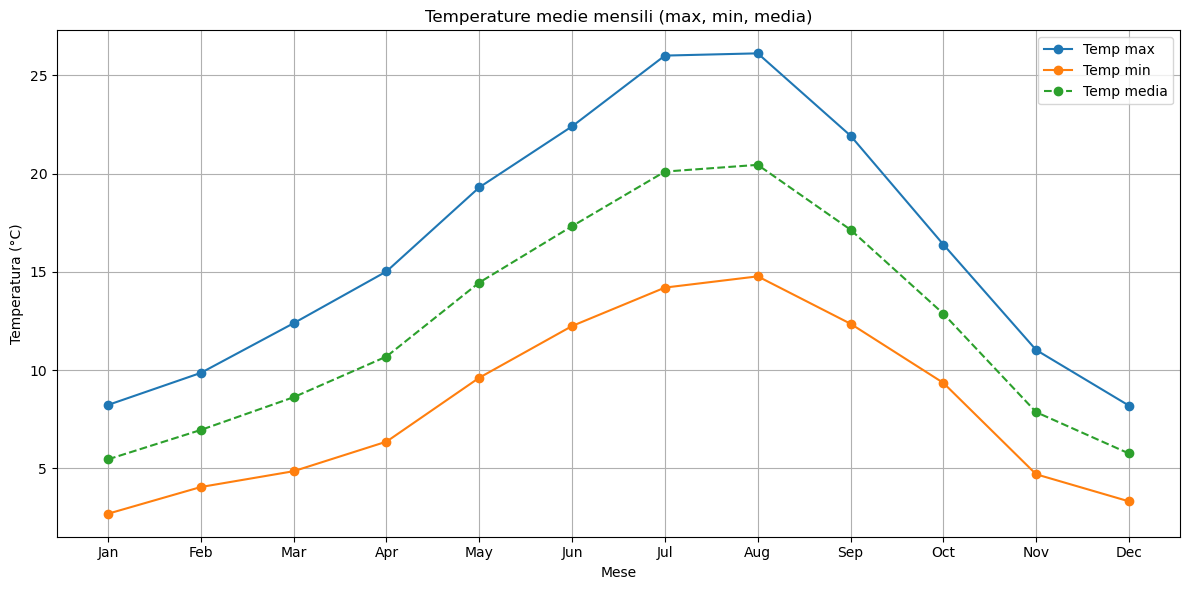

In [49]:
monthly_mean = dataset.groupby('month')[['temp_max', 'temp_min', 'temp_mean']].mean()

month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12,6))
plt.plot(month_name, monthly_mean['temp_max'], marker='o', label='Temp max')
plt.plot(month_name, monthly_mean['temp_min'], marker='o', label='Temp min')
plt.plot(month_name, monthly_mean['temp_mean'], marker='o', label='Temp media', linestyle='--')

plt.title('Temperature medie mensili (max, min, media)')
plt.xlabel('Mese')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

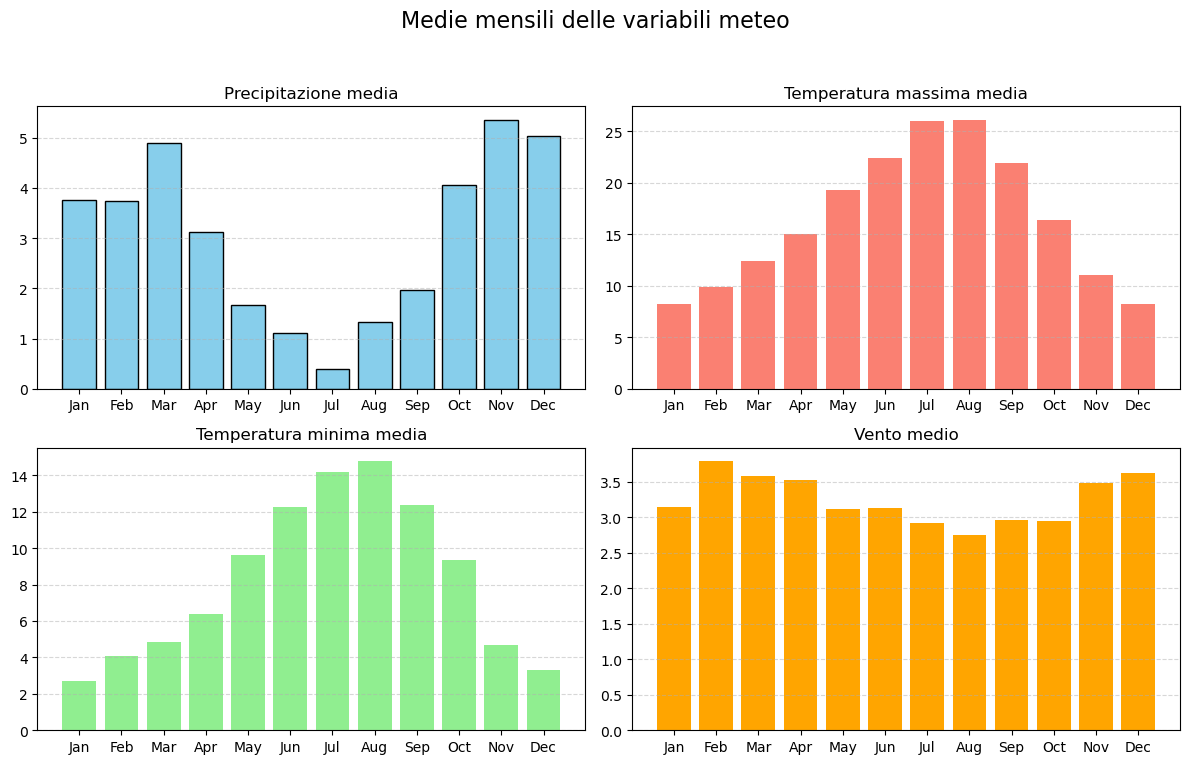

In [54]:
grouped = dataset.groupby('month')[['precipitation', 'temp_max', 'temp_min', 'wind']].mean()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# Precipitazione media
ax1.bar(grouped.index, grouped['precipitation'], color='skyblue', edgecolor='black')
ax1.set_title('Precipitazione media')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_name)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Temp max
ax2.bar(grouped.index, grouped['temp_max'], color='salmon')
ax2.set_title('Temperatura massima media')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_name)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Temp min
ax3.bar(grouped.index, grouped['temp_min'], color='lightgreen')
ax3.set_title('Temperatura minima media')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(month_name)
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Vento
ax4.bar(grouped.index, grouped['wind'], color='orange')
ax4.set_title('Vento medio')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_name)
ax4.grid(axis='y', linestyle='--', alpha=0.5)

# Titolo generale
fig.suptitle('Medie mensili delle variabili meteo', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()